In [21]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style='darkgrid', context='notebook')
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from figures.plotting import plot_metrics_vs_other, plot_correlations

benchmark = 'dicarlo.MajajHong2015.IT.public-pls'
classifier = 'prototype'
pooling_enc = False
dataset_nshot = 'imagenet'
pooling_nshot = True

data = pd.merge(pd.read_csv(f'../results/encoding|benchmark:{benchmark}|pooling:{pooling_enc}.csv'),
                pd.read_csv(f'../results/n-shot|dataset:{dataset_nshot}|classifier:{classifier}|pooling:{pooling_nshot}.csv'), 
                on=['architecture', 'task', 'kind', 'source', 'layer'])

metric_columns = ['accuracy (top 1)', 'accuracy (top 5)']
if classifier == 'linear':
    metric_columns.append('log likelihood')

data = data.drop('i_repeat', axis='columns')
data = data.groupby([c for c in data.columns if c not in metric_columns], as_index=False).mean()

for metric in metric_columns.copy():
    data[f'{metric} (log)'] = np.log(data[metric])
    metric_columns.append(f'{metric} (log)')

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

data.head()

,layer,score,score_error,architecture,task,kind,source,n_train,accuracy (top 1),accuracy (top 5),accuracy (top 1) (log),accuracy (top 5) (log)
0,layer1.0.relu,0.225927,0.005019,ResNet18,Auto-Encoder,Self-Supervised,VVS,1,0.02612,0.11936,-3.645054,-2.125611
1,layer1.0.relu,0.225927,0.005019,ResNet18,Auto-Encoder,Self-Supervised,VVS,5,0.03508,0.14960,-3.350124,-1.899790
2,layer1.0.relu,0.225927,0.005019,ResNet18,Auto-Encoder,Self-Supervised,VVS,20,0.03920,0.17196,-3.239079,-1.760493
3,layer1.0.relu,0.225927,0.005019,ResNet18,Auto-Encoder,Self-Supervised,VVS,50,0.04460,0.18172,-3.110021,-1.705288
4,layer1.0.relu,0.229982,0.003690,ResNet18,Relative Position,Self-Supervised,VVS,1,0.03948,0.15680,-3.231961,-1.852784


---
# All models and layers

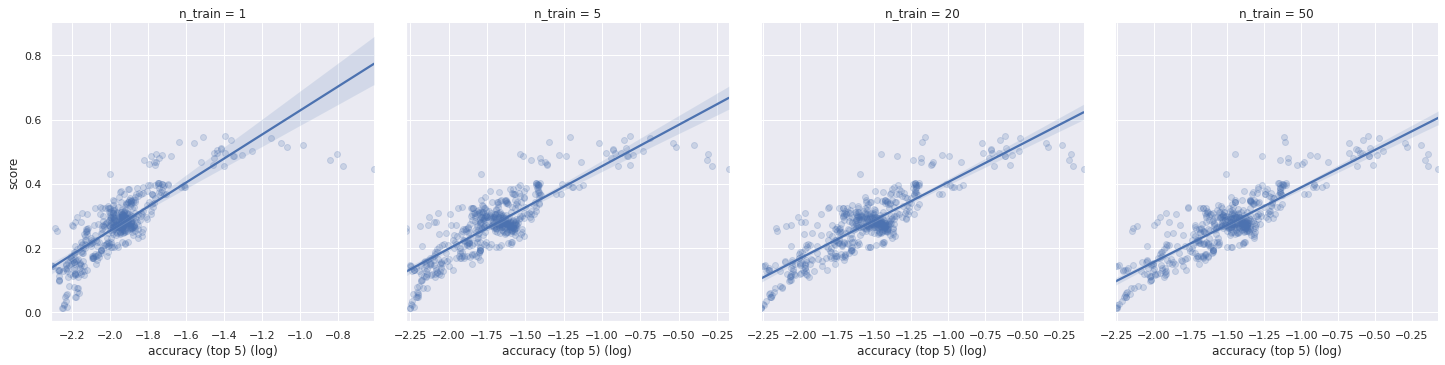

In [63]:
results = data
g = sns.lmplot(data=results, x='accuracy (top 5) (log)', y='score', col='n_train',
               scatter_kws={'alpha':0.2}, sharex=False, sharey='row', height=5)
plt.show()

---
# ResNet 18

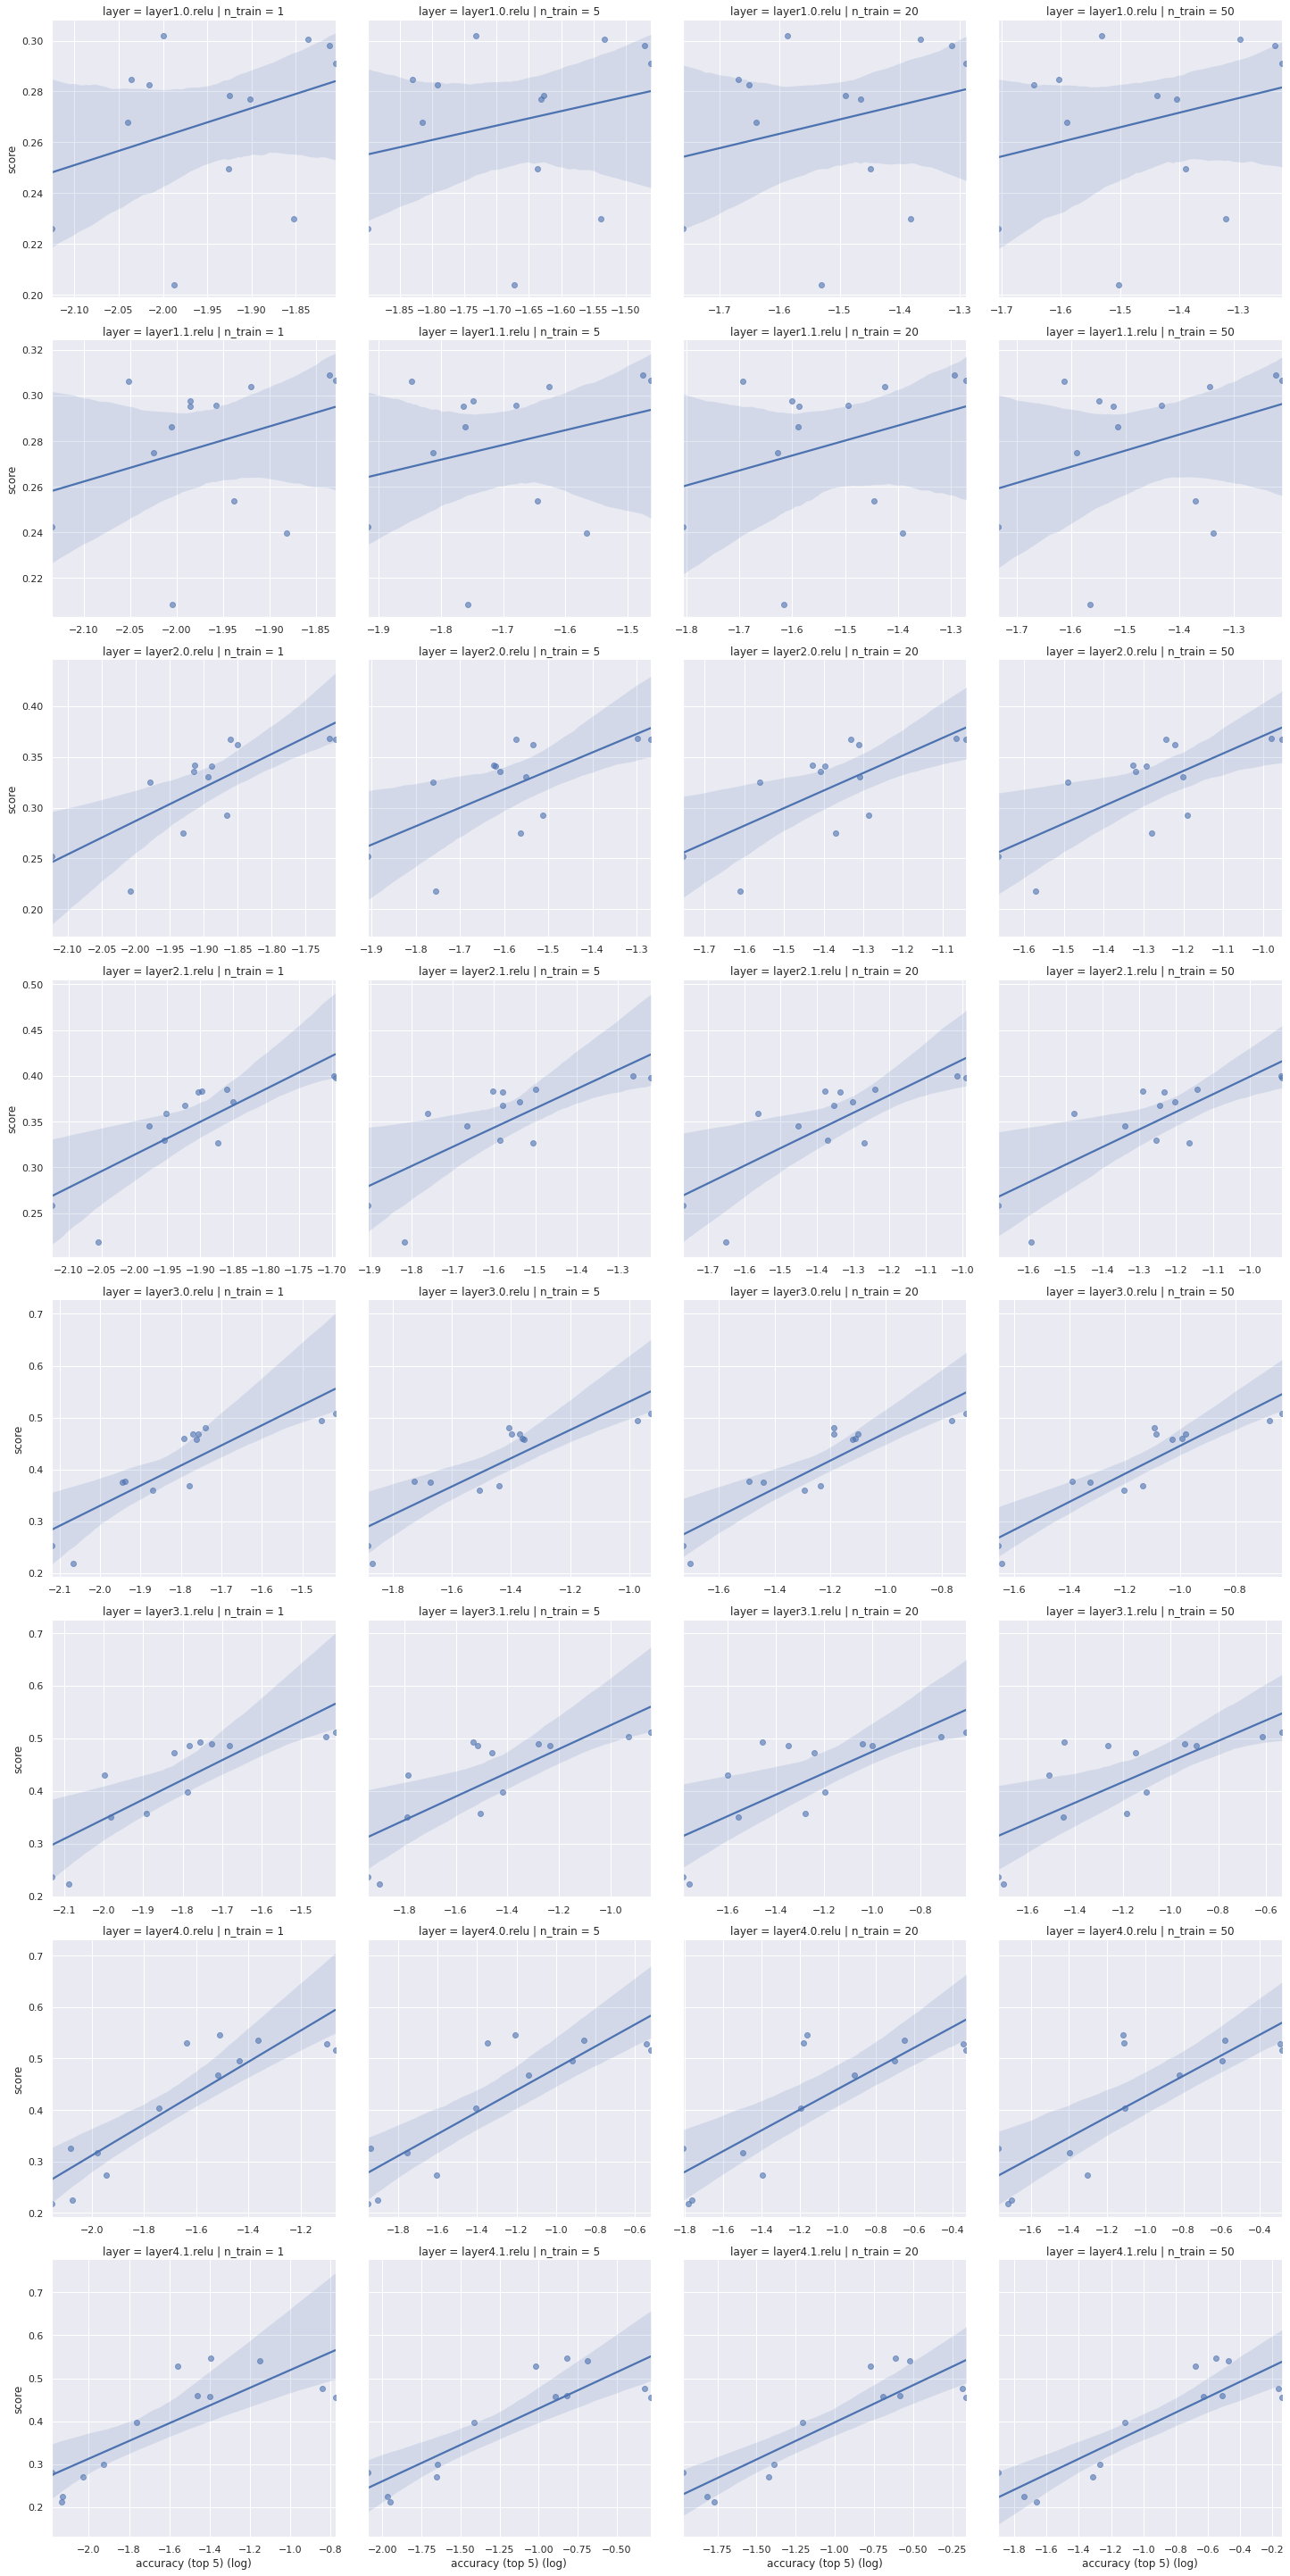

In [64]:
results = data[(data.architecture == 'ResNet18')]
g = sns.lmplot(data=results, x='accuracy (top 5) (log)', y='score', col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=False, sharey='row', height=5)
plt.show()

---
# Taskonomy (ResNet 50)

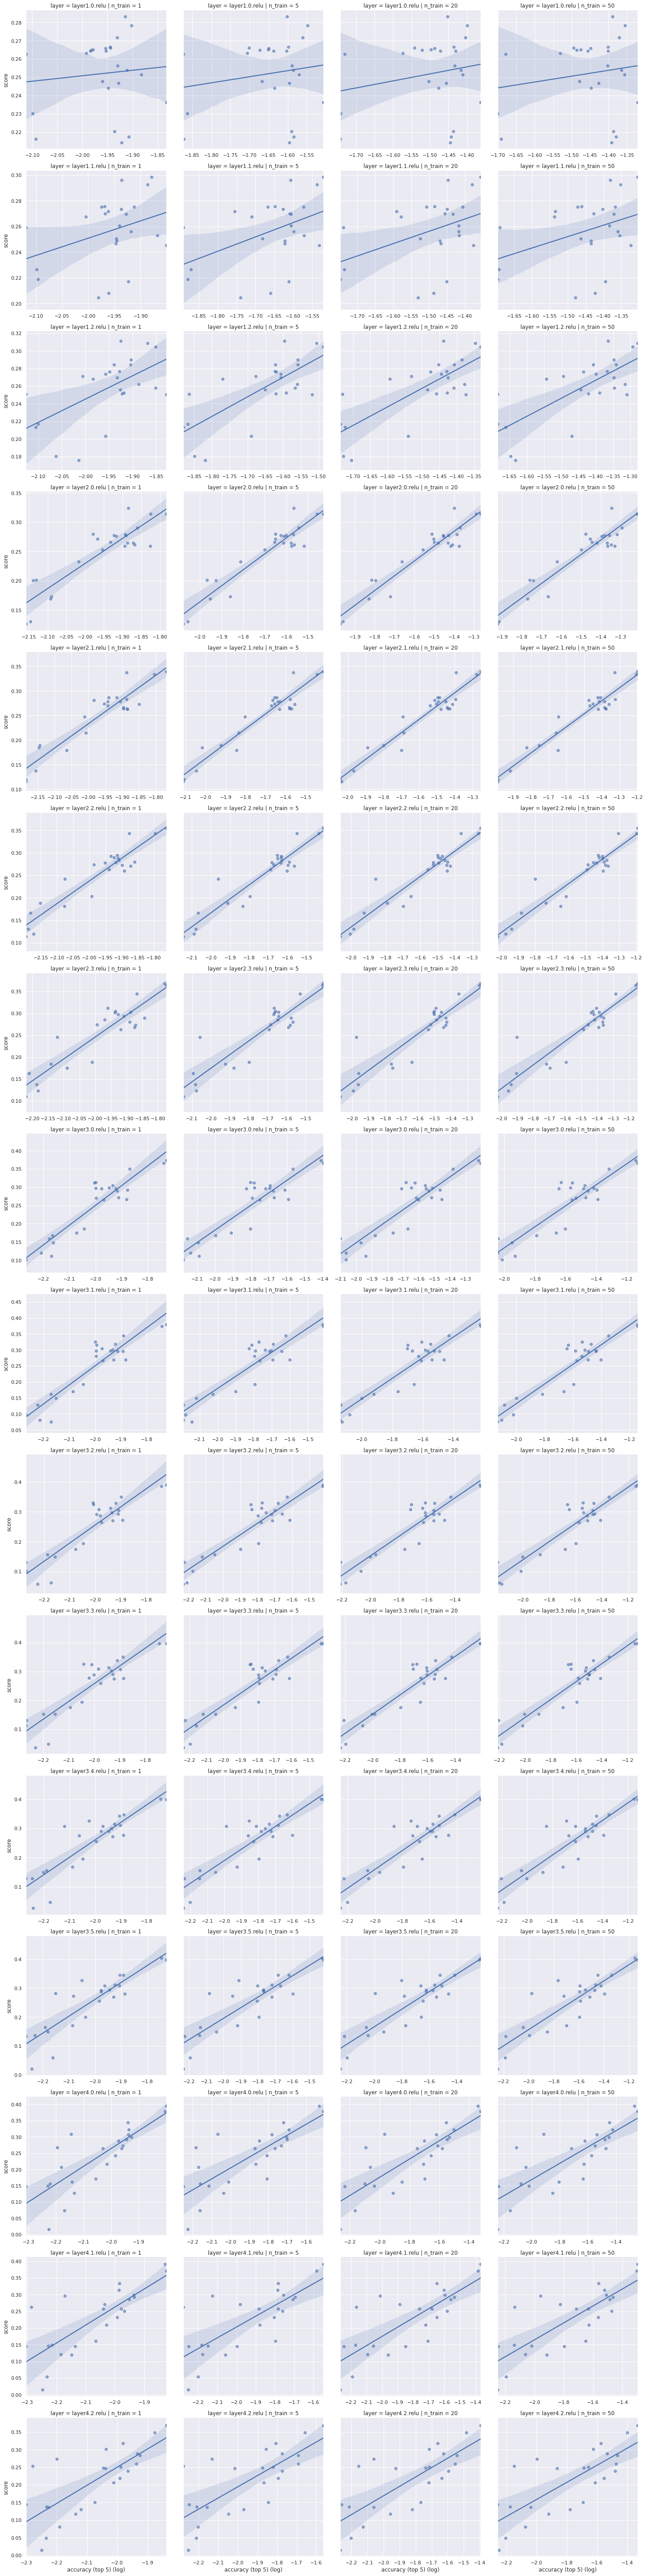

In [65]:
results = data[(data.source == 'Taskonomy')]
g = sns.lmplot(data=results, x='accuracy (top 5) (log)', y='score', col='n_train', row='layer',
               scatter_kws={'alpha':0.6}, sharex=False, sharey='row', height=5)
plt.show()